<a href="https://www.kaggle.com/code/kerthi99055/diabeticretinopaty?scriptVersionId=210356863" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/kerthi99055/diabeticretinopaty?scriptVersionId=209316852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/aptos2019/valid.csv
/kaggle/input/aptos2019/test.csv
/kaggle/input/aptos2019/train_1.csv
/kaggle/input/aptos2019/val_images/val_images/17f6c7072f61.png
/kaggle/input/aptos2019/val_images/val_images/0243404e8a00.png
/kaggle/input/aptos2019/val_images/val_images/0083ee8054ee.png
/kaggle/input/aptos2019/val_images/val_images/0ac436400db4.png
/kaggle/input/aptos2019/val_images/val_images/0d0a21fd354f.png
/kaggle/input/aptos2019/val_images/val_images/02da652c74b8.png
/kaggle/input/aptos2019/val_images/val_images/15e96e848b46.png
/kaggle/input/aptos2019/val_images/val_images/059bc89df7f4.png
/kaggle/input/aptos2019/val_images/val_images/04d029cfb612.png
/kaggle/input/aptos2019/val_images/val_images/08752092140d.png
/kaggle/input/aptos2019/val_images/val_images/0ef4c61dc056.png
/kaggle/input/aptos2019/val_images/val_images/1a7e3356b39c.png
/kaggle/input/aptos2019/val_images/val_images/06be1092a062.png
/kaggle/input/aptos2019/val_images/val_images/03a7f4a5786f.png
/kaggle/input/a

In [3]:
import pandas as pd
import os
import shutil

# Paths
train_csv_path = "/kaggle/input/aptos2019/train_1.csv"  # Path to train CSV
train_images_path = "/kaggle/input/aptos2019/train_images/train_images"  # Path to train images folder
output_yes_images = "/kaggle/working/yes/images/"  # Folder for diagnosis images
output_yes_csv = "/kaggle/working/yes/csv/"  # Folder for yes CSV
output_no_images = "/kaggle/working/no/images/"  # Folder for no-diagnosis images
output_no_csv = "/kaggle/working/no/csv/"  # Folder for no CSV

# Create output directories if they don't exist
os.makedirs(output_yes_images, exist_ok=True)
os.makedirs(output_yes_csv, exist_ok=True)
os.makedirs(output_no_images, exist_ok=True)
os.makedirs(output_no_csv, exist_ok=True)

# Load train CSV
train_df = pd.read_csv(train_csv_path)

# Separate into two groups
yes_df = train_df[train_df['diagnosis'] > 0]
no_df = train_df[train_df['diagnosis'] == 0]

# Copy images to respective folders
for _, row in yes_df.iterrows():
    image_id = row['id_code']
    src_path = os.path.join(train_images_path, f"{image_id}.png")
    dst_path = os.path.join(output_yes_images, f"{image_id}.png")
    if os.path.exists(src_path): 
        shutil.copy(src_path, dst_path)

for _, row in no_df.iterrows():
    image_id = row['id_code']
    src_path = os.path.join(train_images_path, f"{image_id}.png")
    dst_path = os.path.join(output_no_images, f"{image_id}.png")
    if os.path.exists(src_path): 
        shutil.copy(src_path, dst_path)

# Save CSVs
yes_csv_path = os.path.join(output_yes_csv, "yes.csv")
no_csv_path = os.path.join(output_no_csv, "no.csv")

yes_df.to_csv(yes_csv_path, index=False)
no_df.to_csv(no_csv_path, index=False)

print(f"Images with diagnosis (1-4) saved to '{output_yes_images}' and listed in '{yes_csv_path}'.")
print(f"Images with no diagnosis (0) saved to '{output_no_images}' and listed in '{no_csv_path}'.")


Images with diagnosis (1-4) saved to '/kaggle/working/yes/images/' and listed in '/kaggle/working/yes/csv/yes.csv'.
Images with no diagnosis (0) saved to '/kaggle/working/no/images/' and listed in '/kaggle/working/no/csv/no.csv'.


In [4]:
yes_images_count = len(os.listdir(output_yes_images))
no_images_count = len(os.listdir(output_no_images))

print(f"Number of 'yes' images (labels 1-4): {yes_images_count}")
print(f"Number of 'no' images (label 0): {no_images_count}")

Number of 'yes' images (labels 1-4): 1496
Number of 'no' images (label 0): 1434


In [5]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [6]:
def load_and_preprocess_image(image_path):
    """
    Loads and preprocesses an image for ResNet.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        return None  # Skip if image is not found

    # Convert to RGB and resize
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # Normalize the image
    image = image / 255.0
    return image

In [7]:
# Paths to directories
main_directory = r"/kaggle/working/"
yes_directory = os.path.join(main_directory, "yes/images")
no_directory = os.path.join(main_directory, "no/images")

# Data containers
train_images = []
train_labels = []

# Load and preprocess 'yes' images
for image_file in os.listdir(yes_directory):
    image_path = os.path.join(yes_directory, image_file)
    image_array = load_and_preprocess_image(image_path)
    if image_array is not None:
        train_images.append(image_array)
        train_labels.append(1)  # Label for 'yes'

# Load and preprocess 'no' images
for image_file in os.listdir(no_directory):
    image_path = os.path.join(no_directory, image_file)
    image_array = load_and_preprocess_image(image_path)
    if image_array is not None:
        train_images.append(image_array)
        train_labels.append(0)  # Label for 'no'

# Convert lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Optionally one-hot encode labels
train_labels = to_categorical(train_labels, num_classes=2)

# Summary
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train images shape: (2930, 224, 224, 3)
Train labels shape: (2930, 2)


In [8]:

def preprocess_validation_data(image_dir, csv_path):
    """
    Preprocess validation images and labels for model training.
    
    Args:
        image_dir (str): Directory containing validation images.
        csv_path (str): Path to the CSV file containing image IDs and labels.

    Returns:
        tuple: (valid_images, valid_labels)
    """
    # Read the CSV file
    valid_df = pd.read_csv(csv_path)

    # Map the labels: 0 -> 0 (no), 1/2/3/4 -> 1 (yes)
    valid_df['diagnosis'] = valid_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

    valid_images = []
    valid_labels = []

    for _, row in valid_df.iterrows():
        image_id = row['id_code']
        label = row['diagnosis']

        # Construct the image path
        image_path = os.path.join(image_dir, f"{image_id}.png")

        # Load and preprocess the image
        image_array = load_and_preprocess_image(image_path)  # Function defined earlier
        if image_array is not None:
            valid_images.append(image_array)
            valid_labels.append(label)

    # Convert lists to arrays
    valid_images = np.array(valid_images)
    valid_labels = np.array(valid_labels)

    # One-hot encode the labels for ResNet
    valid_labels = to_categorical(valid_labels, num_classes=2)

    return valid_images, valid_labels

# Paths to validation data
val_image_dir = "/kaggle/input/aptos2019/val_images/val_images"
val_csv_path = "/kaggle/input/aptos2019/valid.csv"

# Preprocess validation data
valid_images, valid_labels = preprocess_validation_data(val_image_dir, val_csv_path)

# Summary
print(f"Validation images shape: {valid_images.shape}")
print(f"Validation labels shape: {valid_labels.shape}")


Validation images shape: (366, 224, 224, 3)
Validation labels shape: (366, 2)


In [9]:
train_images = np.array(train_images)  
train_labels = np.array(train_labels)  
valid_images = np.array(valid_images)  
valid_labels = np.array(valid_labels)  

In [10]:
# Define data augmentation for the training set
data_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define ResNet50 model
def create_resnet50_model(input_shape, num_classes):
    # Load ResNet50 base model with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Compile the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=tf.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [11]:
def lr_schedule(epoch, lr):
    # Example: Decrease learning rate by 10% every 5 epochs
    if epoch % 5 == 0 and epoch > 0:
        lr *= 0.9
    return float(lr)  # Ensure the return value is a float

# Create LearningRateScheduler callback with the corrected schedule function
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
# Model configuration
input_shape = (224, 224, 3)
num_classes = 2  # Yes and No classes
model = create_resnet50_model(input_shape, num_classes)

# Training the model
history = model.fit(
    data_gen.flow(train_images, train_labels, batch_size=32),
    epochs=25,
    validation_data=(valid_images, valid_labels),
    callbacks=[early_stopping, learning_rate_scheduler]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


I0000 00:00:1732438167.258636     123 service.cc:145] XLA service 0x78553804abe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732438167.258715     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732438167.258720     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/92 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.5469 - loss: 0.7787  

I0000 00:00:1732438173.016741     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 384ms/step - accuracy: 0.4932 - loss: 0.7180 - val_accuracy: 0.5301 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - accuracy: 0.5203 - loss: 0.6906 - val_accuracy: 0.6120 - val_loss: 0.6717 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.5525 - loss: 0.6813 - val_accuracy: 0.4973 - val_loss: 0.6667 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - accuracy: 0.5880 - loss: 0.6734 - val_accuracy: 0.6585 - val_loss: 0.6437 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.6142 - loss: 0.6633 - val_accuracy: 0.6639 - val_loss: 0.6403 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.6114 - loss: 0.6598 - val_accuracy: 0.6011 - val_loss: 0.6395 - learning_rate: 9.0000e-05
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.65

In [13]:
import os

# Create directory if it doesn't exist
save_dir = '/kaggle/working/'
os.makedirs(save_dir, exist_ok=True)

# Ensure file paths are valid
weights_path = './resnet50_model_weights.weights.h5'
model_path = './resnet50_model.h5'

# Debug paths
print(f"Saving weights to: {weights_path}")
print(f"Saving model to: {model_path}")

# Save weights and model
model.save_weights(weights_path)
model.save(model_path)

print("Model and weights saved successfully!")


# Debug the paths
print(f"Saving weights to: {weights_path}")
print(f"Saving model to: {model_path}")

# Save weights and model
model.save_weights(weights_path)
model.save(model_path)

print("Model and weights saved successfully!")


Saving weights to: ./resnet50_model_weights.weights.h5
Saving model to: ./resnet50_model.h5
Model and weights saved successfully!
Saving weights to: ./resnet50_model_weights.weights.h5
Saving model to: ./resnet50_model.h5
Model and weights saved successfully!


In [14]:

# Evaluate the model
results = model.evaluate(valid_images, valid_labels, batch_size=32)
print(f"Validation Loss: {results[0]}, Validation Accuracy: {results[1]}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8468 - loss: 0.4851
Validation Loss: 0.4812837541103363, Validation Accuracy: 0.8469945192337036


In [15]:
test_dir = "/kaggle/input/aptos2019/test_images/test_images"
if os.path.exists(test_dir):
    print("Directory exists.")
    print("Files:", os.listdir(test_dir))
else:
    print("Directory does not exist!")


Directory exists.
Files: ['ef476be214d4.png', 'ec363f48867b.png', 'f481f76a6b75.png', 'fa7fa797c650.png', 'e7578d8dba72.png', 'eda29a9d78f3.png', 'fe0e2dee1834.png', 'e933923aab15.png', 'ef99c499d665.png', 'fc8fce67fbf8.png', 'e9286ddf6ffe.png', 'f0098e9d4aee.png', 'ea1d045f9fea.png', 'e7291472109b.png', 'fd48cf452e9d.png', 'eedae6b28f96.png', 'ef81cd8854cb.png', 'f366fb1cc475.png', 'f7e9fa75c7c1.png', 'e5de79795c1d.png', 'eae70f527755.png', 'f7116e7b2f4e.png', 'fb696a8e055a.png', 'e6a6acf7fca1.png', 'f9aa35187bf3.png', 'ea15a290eb96.png', 'ed6bd9293a89.png', 'fc898dfeb24f.png', 'f6f433f3306f.png', 'e60e4edb3ca9.png', 'fa3e544a7401.png', 'f56ff0440ed1.png', 'f09fd9433dff.png', 'ef8c39eb9157.png', 'fdd18ccbbdc5.png', 'f09cfc6a4dbd.png', 'e9f3c85a2a02.png', 'ecad6845f630.png', 'e62490b7d0e9.png', 'eb32a815f78c.png', 'ef247f28004f.png', 'e8ddfc9709ce.png', 'fe06dad6851c.png', 'f850cb51fdba.png', 'fa9f1bc03f21.png', 'fd62bd0db4f1.png', 'f62b8a076833.png', 'f0546a45ef10.png', 'f6d760566a51.

In [19]:
from tensorflow.keras.preprocessing import image  
def preprocess_test_data(image_dir, csv_path):
    """
    Preprocess test images and labels for model evaluation.
    
    Args:
        image_dir (str): Directory containing test images.
        csv_path (str): Path to the CSV file containing image IDs and labels.

    Returns:
        tuple: (test_images, test_labels)
    """
    # Read the CSV file
    test_df = pd.read_csv(csv_path)

    # Map the labels: 0 -> 0 (no), 1/2/3/4 -> 1 (yes)
    test_df['diagnosis'] = test_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

    test_images = []
    test_labels = []

    for _, row in test_df.iterrows():
        image_id = row['id_code']
        label = row['diagnosis']

        # Construct the image path
        image_path = os.path.join(image_dir, f"{image_id}.png")

        # Load and preprocess the image
        try:
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize the image
            test_images.append(img_array)
            test_labels.append(label)
        except FileNotFoundError:
            print(f"Image {image_id}.png not found. Skipping...")

    # Convert lists to arrays
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # One-hot encode the labels for ResNet
    test_labels = to_categorical(test_labels, num_classes=2)

    return test_images, test_labels

# Paths to test data
test_image_dir = "/kaggle/input/aptos2019/test_images/test_images"
test_csv_path = "/kaggle/input/aptos2019/test.csv"

# Preprocess test data
test_images, test_labels = preprocess_test_data(test_image_dir, test_csv_path)

# Summary
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Test images shape: (366, 224, 224, 3)
Test labels shape: (366, 2)


In [20]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the preprocessed test images and labels (from your previous preprocessing step)
test_images = np.array(test_images)  # From the preprocessing step (test images)
test_labels = np.array(test_labels)  # From the preprocessing step (test labels)

# If the labels are one-hot encoded, convert them to integer labels
test_labels = np.argmax(test_labels, axis=1)

# Load your trained model
model = tf.keras.models.load_model("/kaggle/working/resnet50_model.h5")  # Path to your trained model

# Predict using the trained model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted class indices

# Calculate accuracy manually
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"Manual Test Accuracy: {accuracy * 100:.2f}%")

# Generate a classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(test_labels, predicted_classes, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(test_labels, predicted_classes)
print(conf_matrix)

# Optionally, print predictions for each image
for i, (true_label, pred_label) in enumerate(zip(test_labels, predicted_classes)):
    print(f"Image {i + 1}: True Label: {true_label}, Predicted Label: {pred_label}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step
Manual Test Accuracy: 85.52%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.86      0.87       199
     Class 1       0.84      0.84      0.84       167

    accuracy                           0.86       366
   macro avg       0.85      0.85      0.85       366
weighted avg       0.86      0.86      0.86       366


Confusion Matrix:
[[172  27]
 [ 26 141]]
Image 1: True Label: 0, Predicted Label: 0
Image 2: True Label: 1, Predicted Label: 1
Image 3: True Label: 1, Predicted Label: 0
Image 4: True Label: 0, Predicted Label: 0
Image 5: True Label: 0, Predicted Label: 0
Image 6: True Label: 0, Predicted Label: 0
Image 7: True Label: 1, Predicted Label: 1
Image 8: True Label: 1, Predicted Label: 1
Image 9: True Label: 1, Predicted Label: 1
Image 10: True Label: 1, Predicted Label: 1
Image 11: True Label: 0, Predicted Label: 0
Image 12: True Label: 0, Predicted Label: 0
Image 13: True Lab

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image ID: e66ad813a508
True Label: 0
Predicted Label: 0
Prediction Confidence: 0.55


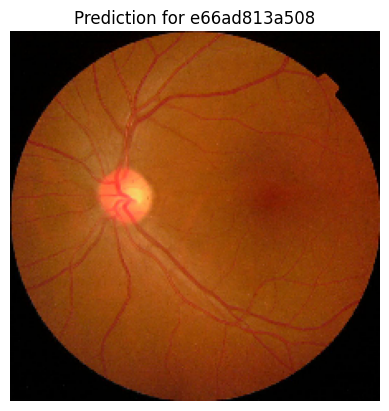

In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model("/kaggle/working/resnet50_model.h5")

# Path to the test CSV and test image directory
test_csv_path = "/kaggle/input/aptos2019/test.csv"
test_image_dir = "/kaggle/input/aptos2019/test_images/test_images"

# Read the test CSV file
test_df = pd.read_csv(test_csv_path)

# Map the labels: 0 -> 0 (no), 1/2/3/4 -> 1 (yes)
test_df['diagnosis'] = test_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

# Function to predict a single image and compare with the true label
def predict_single_image(image_id, image_dir, test_df, model):
    """
    Predict the label of a single test image and compare it with the true label.

    Args:
        image_id (str): The ID of the image to predict.
        image_dir (str): Directory containing test images.
        test_df (DataFrame): DataFrame with image IDs and true labels.
        model (Model): The trained model.

    Returns:
        None
    """
    # Construct the image path
    image_path = os.path.join(image_dir, f"{image_id}.png")
    
    # Load and preprocess the image
    try:
        img = image.load_img(image_path, target_size=(224, 224))  # Resize to model input size
        img_array = image.img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Predict the label
        prediction = model.predict(img_array)
        predicted_label = np.argmax(prediction, axis=1)[0]  # Predicted class
        
        # Get the true label from the CSV file
        true_label = test_df.loc[test_df['id_code'] == image_id, 'diagnosis'].values[0]
        
        # Print results
        print(f"Image ID: {image_id}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Prediction Confidence: {prediction[0][predicted_label]:.2f}")
        
        # Visual feedback (if running locally or with visualization support)
        return img

    except FileNotFoundError:
        print(f"Image {image_id}.png not found. Please check the path.")
        return None

# Test the function with a sample image ID
sample_image_id = test_df['id_code'].iloc[26]  
output_img = predict_single_image(sample_image_id, test_image_dir, test_df, model)

# Display the image (optional, works in environments supporting matplotlib)
if output_img is not None:
    import matplotlib.pyplot as plt
    plt.imshow(output_img)
    plt.title(f"Prediction for {sample_image_id}")
    plt.axis("off")
    plt.show()


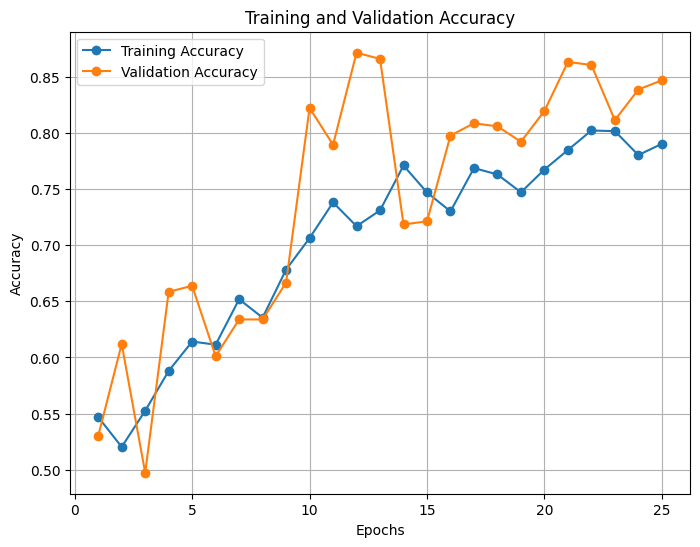

In [6]:
import matplotlib.pyplot as plt

# Data from the training log
epochs = list(range(1, 26))
train_accuracy = [0.5469, 0.5203, 0.5525, 0.5880, 0.6142, 0.6114, 0.6519, 0.6355, 0.6783, 0.7064, 0.7382, 0.7170, 
                  0.7311, 0.7711, 0.7471, 0.7302, 0.7688, 0.7631, 0.7472, 0.7675, 0.7849, 0.8023, 0.8017, 0.7804, 0.7904]
val_accuracy = [0.5301, 0.6120, 0.4973, 0.6585, 0.6639, 0.6011, 0.6339, 0.6339, 0.6667, 0.8224, 0.7896, 0.8716, 
                0.8661, 0.7186, 0.7213, 0.7978, 0.8087, 0.8060, 0.7923, 0.8197, 0.8634, 0.8607, 0.8115, 0.8388, 0.8470]
train_loss = [0.7787, 0.6906, 0.6813, 0.6734, 0.6633, 0.6598, 0.6568, 0.6436, 0.6420, 0.6330, 0.6248, 0.6191, 
              0.6102, 0.5967, 0.5948, 0.5970, 0.5853, 0.5777, 0.5768, 0.5767, 0.5653, 0.5589, 0.5528, 0.5525, 0.5487]
val_loss = [0.6832, 0.6717, 0.6667, 0.6437, 0.6403, 0.6395, 0.6172, 0.6117, 0.6076, 0.5901, 0.5835, 0.5670, 
            0.5590, 0.5668, 0.5429, 0.5327, 0.5252, 0.5310, 0.5264, 0.5037, 0.4974, 0.4933, 0.5010, 0.4896, 0.4813]

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


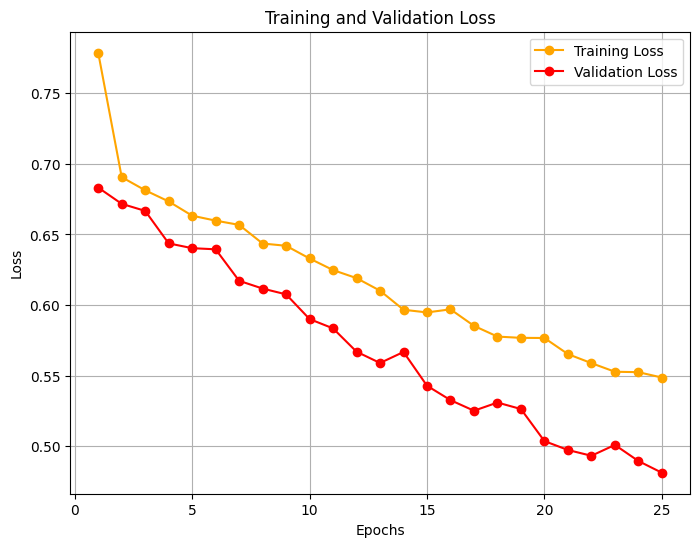

In [7]:
# Plotting training and validation loss
plt.figure(figsize=(8,6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='orange')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

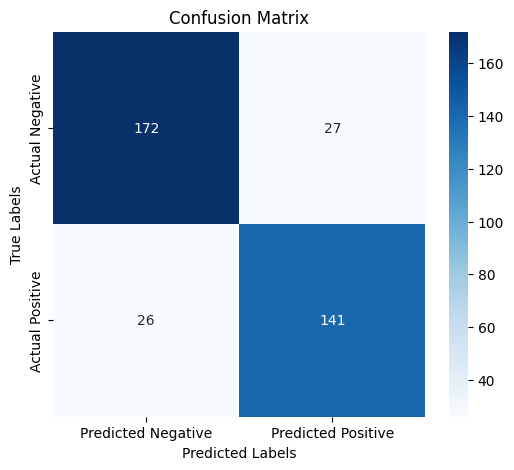

In [9]:
import seaborn as sns
import numpy as np

# Confusion matrix data
confusion_matrix = np.array([[172, 27], [26, 141]])

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
